In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import ast
import numpy as np

In [8]:
AIC = pd.read_csv('../../Data/Rheologu_Oxford/AIC_XHR.csv',index_col=0)
# Ensure competitive_models are parsed as lists, not strings
AIC['competitive_models'] = AIC['competitive_models'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))


Percentage of events with competitive models assigned even weights vs aikike weights

In [51]:
# Create a model support counter
model_weights = defaultdict(float)

# Iterate through each event
for _, row in AIC.iterrows():
    if not row['uncertain']:
        # Certain case: assign full weight to best model
        model_weights[row['best_model']] += 1.0
    else:
        # Uncertain case: divide weight equally among competitive models
        weight = 1.0 / len(row['competitive_models'])
        for model in row['competitive_models']:
            model_weights[model] += weight

# Convert to a Series for easy display/sorting
model_weights_series = pd.Series(model_weights).sort_values(ascending=False)

print(model_weights_series)

# Convert to percentage
total_events = len(AIC)
model_weights_percent = (model_weights_series)# / total_events) * 100

# Round for cleaner display
model_weights_percent = model_weights_percent.round(2)

print(model_weights_percent)


PLV        22.250000
LNV        14.250000
VSFBSS      8.916667
VSFSS       2.416667
VSFASS      1.166667
VSF_aSS     1.000000
dtype: float64
PLV        22.25
LNV        14.25
VSFBSS      8.92
VSFSS       2.42
VSFASS      1.17
VSF_aSS     1.00
dtype: float64


Assigning Aikike weights to columns

In [11]:
# List of your model names (same order as AIC columns and delta_AIC columns)
model_names = ['LNV', 'PLV', 'VSF_SS', 'VSF_aSS', 'VSF_bSS']

# Create empty columns in AIC for each Akaike weight
for model in model_names:
    AIC[f'w_{model}'] = np.nan

# Compute and store Akaike weights row-by-row
for i, row in AIC.iterrows():
    # Get delta AICs as a dict
    delta_aics = {model: row[f'delta_AIC_{model}'] for model in model_names}
    
    # Unnormalised weights
    weights = {model: np.exp(-0.5 * delta) for model, delta in delta_aics.items()}
    
    # Normalise
    total_weight = sum(weights.values())
    akaike_weights = {model: w / total_weight for model, w in weights.items()}
    
    # Assign to DataFrame
    for model in model_names:
        AIC.at[i, f'w_{model}'] = akaike_weights[model]


Bootstrap for confidence intervals

In [ ]:
def bootstrap_model_support(AIC, model_names, n_iterations=1000, sample_size=50, random_state=None):
    """
    Perform bootstrap resampling to estimate percentage support for each model
    based on Akaike weights.

    Args:
        AIC (pd.DataFrame): DataFrame containing Akaike weights with columns
                            named like 'w_MODELNAME'.
        model_names (list of str): List of model names matching suffixes in AIC columns.
        n_iterations (int, optional): Number of bootstrap iterations. Default is 1000.
        sample_size (int, optional): Number of samples per bootstrap iteration. Default is 50.
        random_state (int or None, optional): Seed for reproducibility.

    Returns:
        pd.DataFrame: DataFrame with bootstrap iterations as rows and model support
                      percentages as columns.
    """
    rng = np.random.default_rng(random_state)
    results = []

    for _ in range(n_iterations):
        # Resample with replacement
        resampled = AIC.sample(n=sample_size, replace=True, random_state=rng.integers(0, 1e9))

        # Sum Akaike weights for each model
        support = {
            model: resampled[f'w_{model}'].sum() / sample_size * 100
            for model in model_names
        }

        results.append(support)

    return pd.DataFrame(results)

In [14]:
bootstrap_df = bootstrap_model_support(AIC, model_names, n_iterations=1000, sample_size=50, random_state=42)

# Example preview
print(bootstrap_df.head())

         LNV        PLV    VSF_SS   VSF_aSS    VSF_bSS
0  26.582706  34.796372  8.633957  5.493094  24.493870
1  29.925763  43.300962  3.957383  4.325755  18.490138
2  33.671964  37.030614  6.075571  3.593300  19.628551
3  30.794991  39.923686  5.684636  5.955914  17.640773
4  25.267840  38.765211  7.139662  7.578512  21.248775


In [ ]:
colors = {'VSF_SS': '#a50026','VSF_aSS': '#f46d43','VSF_bSS': '#fee090','LNV': '#74add1','PLV': '#313695'}


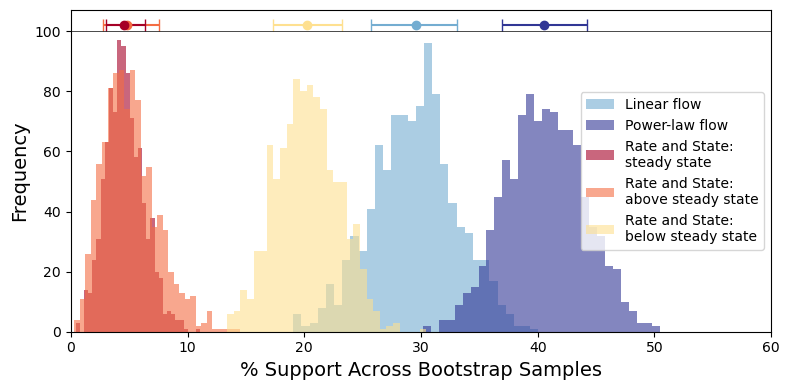

In [49]:
# CI summary table as before
ci_summary = bootstrap_df.quantile([0.15, 0.5, 0.85]).T
ci_summary.columns = ['15th', '50th', '85th']
ci_summary = ci_summary.sort_values('50th', ascending=False)


plt.figure(figsize=(8, 4))

# Overlay histograms with transparency so they don't block each other
plt.hist(bootstrap_df['LNV'], bins=30, color=colors['LNV'], alpha=0.6, label='Linear flow')
plt.hist(bootstrap_df['PLV'], bins=30, color=colors['PLV'], alpha=0.6, label='Power-law flow')
plt.hist(bootstrap_df['VSF_SS'], bins=30, color=colors['VSF_SS'], alpha=0.6, label='Rate and State:\nsteady state')
plt.hist(bootstrap_df['VSF_aSS'], bins=30, color=colors['VSF_aSS'], alpha=0.6, label='Rate and State:\nabove steady state')
plt.hist(bootstrap_df['VSF_bSS'], bins=30, color=colors['VSF_bSS'], alpha=0.6, label='Rate and State:\nbelow steady state')

plt.xlabel('% Support Across Bootstrap Samples',fontsize=14)
plt.ylabel('Frequency',fontsize=14)



for i, model in enumerate(ci_summary.index):
    median = ci_summary.loc[model, '50th']
    low = ci_summary.loc[model, '15th']
    high = ci_summary.loc[model, '85th']
    colour = colors.get(model, 'grey')  # fallback to grey if not found

    plt.errorbar(
        x=median,
        y=102,
        xerr=[[median - low], [high - median]],
        fmt='o',
        color=colour,
        capsize=4,
    )


plt.legend(loc='center right')
plt.xlim([0,60])
plt.hlines(100,0,80,color='k',linewidth=0.5)
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100])
plt.tight_layout()
plt.savefig('histograms_preweight.pdf')
plt.show()

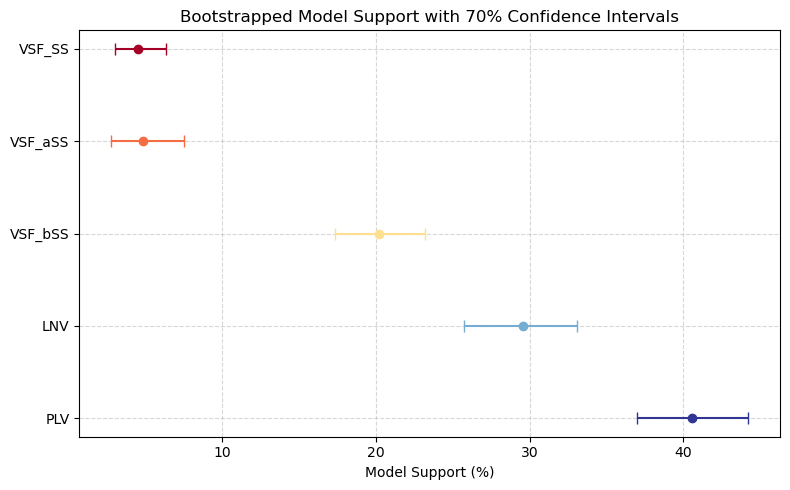

In [ ]:
# CI summary table
ci_summary = bootstrap_df.quantile([0.15, 0.5, 0.85]).T
ci_summary.columns = ['15th', '50th', '85th']
ci_summary = ci_summary.sort_values('50th', ascending=False)



Making LNV -> PLV

In [111]:
AIC_no_LNV = pd.DataFrame({'PLV':AIC['PLV'],'VSF_SS':AIC['VSF_SS'],'VSF_aSS':AIC['VSF_aSS'],'VSF_bSS':AIC['VSF_bSS']})
rheology_XHR = AIC_no_LNV.idxmin(axis=1,skipna=True)
DAIC_PLV = []
DAIC_VSF_SS = []
DAIC_VSF_aSS = []
DAIC_VSF_bSS = []
for i in range(len(AIC_no_LNV)):
    DAIC_PLV.append((AIC_no_LNV.iloc[i] - AIC_no_LNV[rheology_XHR[i]].iloc[i])['PLV'])
    DAIC_VSF_SS.append((AIC_no_LNV.iloc[i] - AIC_no_LNV[rheology_XHR[i]].iloc[i])['VSF_SS'])
    DAIC_VSF_aSS.append((AIC_no_LNV.iloc[i] - AIC_no_LNV[rheology_XHR[i]].iloc[i])['VSF_aSS'])
    DAIC_VSF_bSS.append((AIC_no_LNV.iloc[i] - AIC_no_LNV[rheology_XHR[i]].iloc[i])['VSF_bSS'])
AIC_no_LNV['delta_AIC_PLV'] = DAIC_PLV
AIC_no_LNV['delta_AIC_VSF_SS'] = DAIC_VSF_SS
AIC_no_LNV['delta_AIC_VSF_aSS'] = DAIC_VSF_aSS
AIC_no_LNV['delta_AIC_VSF_bSS'] = DAIC_VSF_bSS


In [ ]:
def flag_model_selection_uncertainty(aic_df, delta_cols):
    """
    Identify best models and flag uncertainty based on delta AIC values.

    For each row in the DataFrame, this function:
    - Determines the best model with the lowest AIC.
    - Finds models with delta AIC ≤ 2 (competitive models).
    - Flags uncertainty if more than one model is competitive.

    Args:
        aic_df (pd.DataFrame): DataFrame containing AIC and delta AIC values for models.
        delta_cols (list): List of column names in `aic_df` representing delta AIC for each model.

    Returns:
        pd.DataFrame: DataFrame with columns:
            - 'best_model': Model with lowest AIC.
            - 'competitive_models': List of models with delta AIC ≤ 2.
            - 'uncertain': Boolean flag indicating if model selection is uncertain.
    """
    results = []
    
    for idx, row in aic_df.iterrows():
        delta_values = row[delta_cols]
        
        # Get models with delta AIC ≤ 2
        competitive_models = [col.replace('delta_AIC_', '').upper()
                              for col in delta_cols if row[col] <= 2]
        
        best_model = row[['PLV', 'VSF_SS', 'VSF_aSS', 'VSF_bSS']].idxmin()
        
        results.append({
            'best_model': best_model,
            'competitive_models': competitive_models,
            'uncertain': len(competitive_models) > 1
        })
    
    return pd.DataFrame(results)

In [ ]:
delta_cols = ['delta_AIC_PLV', 'delta_AIC_VSF_SS', 'delta_AIC_VSF_aSS', 'delta_AIC_VSF_bSS']
model_selection_flags = flag_model_selection_uncertainty(AIC_no_LNV, delta_cols)

# Combine with original dataframe if you like
AIC_no_LNV = pd.concat([AIC_no_LNV, model_selection_flags], axis=1)

,PLV,VSF_SS,VSF_aSS,VSF_bSS,delta_AIC_PLV,delta_AIC_VSF_SS,delta_AIC_VSF_aSS,delta_AIC_VSF_bSS,best_model,competitive_models,uncertain
0,366.842567,455.356173,458.475122,382.493400,0.000000e+00,88.513606,91.632555,1.565083e+01,PLV,[PLV],False
1,35.352131,103.052165,113.537415,35.352130,8.965694e-07,67.700035,78.185285,0.000000e+00,VSF_bSS,"[PLV, VSF_BSS]",True
2,196.817994,190.157188,189.743064,192.082127,7.074930e+00,0.414124,0.000000,2.339063e+00,VSF_aSS,"[VSF_SS, VSF_ASS]",True
3,15.912085,46.032339,48.454178,18.901370,0.000000e+00,30.120254,32.542093,2.989285e+00,PLV,[PLV],False
4,508.816206,575.457119,579.322303,508.816207,0.000000e+00,66.640913,70.506097,8.583064e-07,PLV,"[PLV, VSF_BSS]",True
5,62.069751,95.923053,97.997934,80.587261,0.000000e+00,33.853302,35.928183,1.851751e+01,PLV,[PLV],False
6,376.545677,493.697987,498.334007,385.764043,0.000000e+00,117.152309,121.788330,9.218365e+00,PLV,[PLV],False
7,720.724408,904.831225,912.343043,720.724409,0.000000e+00,184.106817,191.618634,7.413151e-07,PLV,"[PLV, VSF_BSS]",True
8,167.908839,327.178491,332.347576,167.908837,1.888024e-06,159.269654,164.438739,0.000000e+00,VSF_bSS,"[PLV, VSF_BSS]",True
9,333.794574,472.007818,476.688768,333.794574,0.000000e+00,138.213245,142.894194,3.897405e-07,PLV,"[PLV, VSF_BSS]",True


In [116]:
# List of your model names (same order as AIC columns and delta_AIC columns)
model_names = ['PLV', 'VSF_SS', 'VSF_aSS', 'VSF_bSS']

# Create empty columns in AIC for each Akaike weight
for model in model_names:
    AIC_no_LNV[f'w_{model}'] = np.nan

# Compute and store Akaike weights row-by-row
for i, row in AIC_no_LNV.iterrows():
    # Get delta AICs as a dict
    delta_aics = {model: row[f'delta_AIC_{model}'] for model in model_names}
    
    # Unnormalised weights
    weights = {model: np.exp(-0.5 * delta) for model, delta in delta_aics.items()}
    
    # Normalise
    total_weight = sum(weights.values())
    akaike_weights = {model: w / total_weight for model, w in weights.items()}
    
    # Assign to DataFrame
    for model in model_names:
        AIC_no_LNV.at[i, f'w_{model}'] = akaike_weights[model]
AIC_no_LNV

,PLV,VSF_SS,VSF_aSS,VSF_bSS,delta_AIC_PLV,delta_AIC_VSF_SS,delta_AIC_VSF_aSS,delta_AIC_VSF_bSS,best_model,competitive_models,uncertain,w_PLV,w_VSF_SS,w_VSF_aSS,w_VSF_bSS
0,366.842567,455.356173,458.475122,382.493400,0.000000e+00,88.513606,91.632555,1.565083e+01,PLV,[PLV],False,0.999601,6.016463e-20,1.264940e-20,0.000399
1,35.352131,103.052165,113.537415,35.352130,8.965694e-07,67.700035,78.185285,0.000000e+00,VSF_bSS,"[PLV, VSF_BSS]",True,0.500000,9.956217e-16,5.263215e-18,0.500000
2,196.817994,190.157188,189.743064,192.082127,7.074930e+00,0.414124,0.000000,2.339063e+00,VSF_aSS,"[VSF_SS, VSF_ASS]",True,0.013513,3.776740e-01,4.645613e-01,0.144252
3,15.912085,46.032339,48.454178,18.901370,0.000000e+00,30.120254,32.542093,2.989285e+00,PLV,[PLV],False,0.816774,2.352728e-07,7.009325e-08,0.183226
4,508.816206,575.457119,579.322303,508.816207,0.000000e+00,66.640913,70.506097,8.583064e-07,PLV,"[PLV, VSF_BSS]",True,0.500000,1.690752e-15,2.447742e-16,0.500000
5,62.069751,95.923053,97.997934,80.587261,0.000000e+00,33.853302,35.928183,1.851751e+01,PLV,[PLV],False,0.999905,4.454587e-08,1.578530e-08,0.000095
6,376.545677,493.697987,498.334007,385.764043,0.000000e+00,117.152309,121.788330,9.218365e+00,PLV,[PLV],False,0.990138,3.600767e-26,3.545652e-27,0.009862
7,720.724408,904.831225,912.343043,720.724409,0.000000e+00,184.106817,191.618634,7.413151e-07,PLV,"[PLV, VSF_BSS]",True,0.500000,5.256332e-41,1.228888e-42,0.500000
8,167.908839,327.178491,332.347576,167.908837,1.888024e-06,159.269654,164.438739,0.000000e+00,VSF_bSS,"[PLV, VSF_BSS]",True,0.500000,1.300182e-35,9.807349e-37,0.500000
9,333.794574,472.007818,476.688768,333.794574,0.000000e+00,138.213245,142.894194,3.897405e-07,PLV,"[PLV, VSF_BSS]",True,0.500000,4.856745e-31,4.676168e-32,0.500000


In [117]:
bootstrap_df_no_LNV = bootstrap_model_support(AIC_no_LNV, model_names, n_iterations=1000, sample_size=50, random_state=42)

# Example preview
print(bootstrap_df_no_LNV.head())

         PLV     VSF_SS   VSF_aSS    VSF_bSS
0  50.183656  10.609369  6.325683  32.881292
1  63.931719   5.272131  4.915184  25.880966
2  59.607085   8.108380  4.331323  27.953211
3  60.449467   7.868200  6.877612  24.804721
4  54.753984   8.950662  8.518712  27.776642


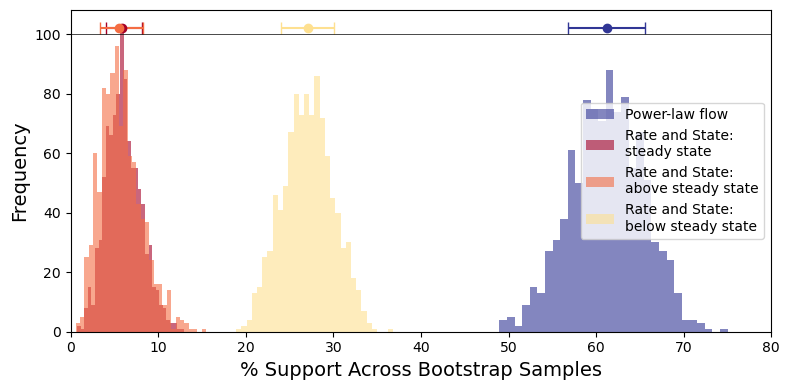

In [120]:
# CI summary table as before
ci_summary_no_LNV = bootstrap_df_no_LNV.quantile([0.15, 0.5, 0.85]).T
ci_summary_no_LNV.columns = ['15th', '50th', '85th']
ci_summary_no_LNV = ci_summary_no_LNV.sort_values('50th', ascending=False)


plt.figure(figsize=(8, 4))

# Overlay histograms with transparency so they don't block each other
plt.hist(bootstrap_df_no_LNV['PLV'], bins=30, color=colors['PLV'], alpha=0.6, label='Power-law flow')
plt.hist(bootstrap_df_no_LNV['VSF_SS'], bins=30, color=colors['VSF_SS'], alpha=0.6, label='Rate and State:\nsteady state')
plt.hist(bootstrap_df_no_LNV['VSF_aSS'], bins=30, color=colors['VSF_aSS'], alpha=0.6, label='Rate and State:\nabove steady state')
plt.hist(bootstrap_df_no_LNV['VSF_bSS'], bins=30, color=colors['VSF_bSS'], alpha=0.6, label='Rate and State:\nbelow steady state')

plt.xlabel('% Support Across Bootstrap Samples',fontsize=14)
plt.ylabel('Frequency',fontsize=14)



for i, model in enumerate(ci_summary_no_LNV.index):
    median = ci_summary_no_LNV.loc[model, '50th']
    low = ci_summary_no_LNV.loc[model, '15th']
    high = ci_summary_no_LNV.loc[model, '85th']
    colour = colors.get(model, 'grey')  # fallback to grey if not found

    plt.errorbar(
        x=median,
        y=102,
        xerr=[[median - low], [high - median]],
        fmt='o',
        color=colour,
        capsize=4,
    )


plt.legend(loc='center right')
plt.xlim([0,80])
plt.hlines(100,0,80,color='k',linewidth=0.5)
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100])
plt.tight_layout()
plt.savefig('histograms_preweight_no_LNV.pdf')
plt.show()

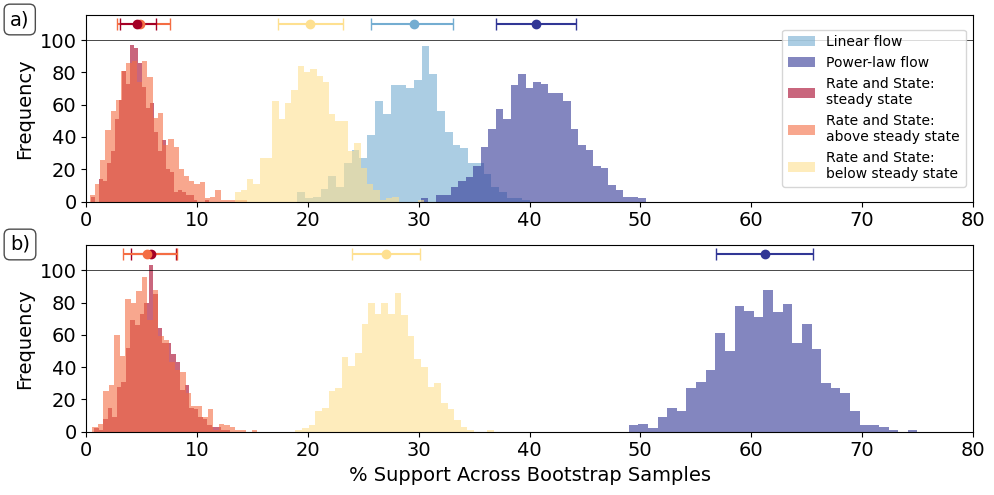

In [142]:
fig = plt.figure(figsize=(10,5))
axa = plt.subplot(2,1,1)
plt.hist(bootstrap_df['LNV'], bins=30, color=colors['LNV'], alpha=0.6, label='Linear flow')
plt.hist(bootstrap_df['PLV'], bins=30, color=colors['PLV'], alpha=0.6, label='Power-law flow')
plt.hist(bootstrap_df['VSF_SS'], bins=30, color=colors['VSF_SS'], alpha=0.6, label='Rate and State:\nsteady state')
plt.hist(bootstrap_df['VSF_aSS'], bins=30, color=colors['VSF_aSS'], alpha=0.6, label='Rate and State:\nabove steady state')
plt.hist(bootstrap_df['VSF_bSS'], bins=30, color=colors['VSF_bSS'], alpha=0.6, label='Rate and State:\nbelow steady state')

#plt.xlabel('% Support Across Bootstrap Samples')
plt.ylabel('Frequency',fontsize=14)
#plt.legend()


for i, model in enumerate(ci_summary.index):
    median = ci_summary.loc[model, '50th']
    low = ci_summary.loc[model, '15th']
    high = ci_summary.loc[model, '85th']
    colour = colors.get(model, 'grey')  # fallback to grey if not found

    plt.errorbar(
        x=median,
        y=110,
        xerr=[[median - low], [high - median]],
        fmt='o',
        color=colour,
        capsize=4,
    )


plt.legend(loc='center right')
plt.xlim([0,80])
plt.hlines(100,0,80,color='k',linewidth=0.5)
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100],fontsize=14)
plt.xticks(fontsize=14)

axb = plt.subplot(2,1,2)

plt.hist(bootstrap_df_no_LNV['PLV'], bins=30, color=colors['PLV'], alpha=0.6, label='Power-law flow')
plt.hist(bootstrap_df_no_LNV['VSF_SS'], bins=30, color=colors['VSF_SS'], alpha=0.6, label='Rate and State:\nsteady state')
plt.hist(bootstrap_df_no_LNV['VSF_aSS'], bins=30, color=colors['VSF_aSS'], alpha=0.6, label='Rate and State:\nabove steady state')
plt.hist(bootstrap_df_no_LNV['VSF_bSS'], bins=30, color=colors['VSF_bSS'], alpha=0.6, label='Rate and State:\nbelow steady state')

plt.xlabel('% Support Across Bootstrap Samples',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
for i, model in enumerate(ci_summary_no_LNV.index):
    median = ci_summary_no_LNV.loc[model, '50th']
    low = ci_summary_no_LNV.loc[model, '15th']
    high = ci_summary_no_LNV.loc[model, '85th']
    colour = colors.get(model, 'grey')  # fallback to grey if not found

    plt.errorbar(
        x=median,
        y=110,
        xerr=[[median - low], [high - median]],
        fmt='o',
        color=colour,
        capsize=4,
    )

# Label formatting
plt.hlines(100,0,80,color='k',linewidth=0.5)
plt.xlim([0,80])
plt.xticks(fontsize=14)
plt.yticks([0,20,40,60,80,100],[0,20,40,60,80,100],fontsize=14)
plt.tight_layout()
fig.text(0.01,0.95,'a)',fontsize=14,bbox=dict(facecolor='white', boxstyle='round',alpha=0.7))
fig.text(0.01,0.5,'b)',fontsize=14,bbox=dict(facecolor='white', boxstyle='round',alpha=0.7))

plt.savefig('AIC_model_support_no_LNV.pdf')
plt.show()